# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

2021-08-28 16:47:12.114227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-28 16:47:12.114246: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Dataset

In [5]:
dataset = pd.read_csv('../data/processed_data/active_users_df_10PlusRatings_partial.csv')
anime_df = pd.read_csv('../data/processed_data/anime_df_relevant_PG.csv')
dataset = dataset.sort_values(["user_id", "anime_id"], ascending=(True, True))

In [6]:
dataset.anime_id.nunique()

12106

In [7]:
dataset.user_id.nunique()

4035

In [8]:
anime_id_to_new_id = dict()
id = 1

In [9]:
for index, row in dataset.iterrows():
    if anime_id_to_new_id.get(row['anime_id']) is None:
        anime_id_to_new_id[row['anime_id']] = id
        dataset.at[index, 'anime_id'] = id
        id += 1
    else:
        dataset.at[index, 'anime_id'] = anime_id_to_new_id.get(row['anime_id'])


In [10]:
# Need to map user ID to [1, user_num]
user_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if user_id_to_new_id.get(row['user_id']) is None:
        user_id_to_new_id[row['user_id']] = id
        dataset.at[index, 'user_id'] = id
        id += 1
    else:
        dataset.at[index, 'user_id'] = user_id_to_new_id.get(row['user_id'])


In [11]:
dataset.user_id

3            1
4            1
0            1
9            1
14           1
          ... 
822308    4035
822416    4035
822372    4035
822305    4035
822356    4035
Name: user_id, Length: 822418, dtype: int64

In [13]:
num_users = len(dataset.user_id.unique())
num_animes = len(dataset.anime_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print('Number of movies', num_animes)
print('Number of users', num_users)

Number of movies 12106
Number of users 4035


# Order dataset by user_id and anime_id

In [14]:
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (657934, 3)
test shape:  (164484, 3)


In [36]:
#train = train.reset_index()

In [37]:
# 151519


#train.anime_id.nunique()
#num_animes

In [38]:
#num_animes

# GMF


## Matrix factorisation

In [15]:
import pydot
import graphviz
%matplotlib inline

In [16]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge, concatenate
from tensorflow.keras.utils import model_to_dot
#from keras.utils.visualize_util import model_to_dot
from IPython.display import SVG

In [28]:
from keras.layers import dot

# Let's use a higher latent dimension.
latent_dim = 10

anime_input = Input(shape=[1],name='anime-input')
anime_embedding = Embedding(num_animes + 1, latent_dim, name='anime-embedding')(anime_input)
anime_vec = Flatten(name='anime-flatten')(anime_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = dot([anime_vec, user_vec], axes=1, normalize=False, name='dot-product')

model = Model([user_input, anime_input], prod)
model.compile('adam', 'mean_squared_error'
              #,metrics=['mse']
             )

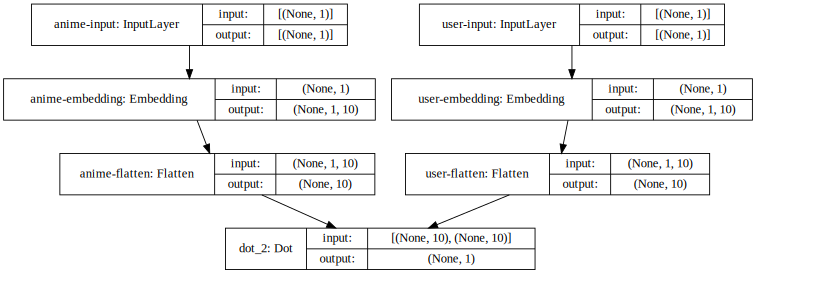

In [32]:
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [29]:
print('user_input',user_input.shape)
print('anime_input',anime_input.shape)

user_input (None, 1)
anime_input (None, 1)


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anime-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime-embedding (Embedding)     (None, 1, 10)        121070      anime-input[0][0]                
__________________________________________________________________________________________________
user-embedding (Embedding)      (None, 1, 10)        40360       user-input[0][0]                 
______________________________________________________________________________________________

In [20]:
dataset.rating = dataset.rating.astype(float)

In [21]:
dataset.dtypes

user_id       int64
anime_id      int64
rating      float64
dtype: object

In [22]:
train.user_id.shape

(657934,)

In [23]:
train.anime_id.shape

(657934,)

In [24]:
train.rating.shape

(657934,)

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

history = model.fit([train.user_id, train.anime_id], train.rating, epochs=10)

Epoch 1/10
20561/20561 [==============================] - 46s 2ms/step - loss: 1.9560
Epoch 2/10
20561/20561 [==============================] - 47s 2ms/step - loss: 1.8728
Epoch 3/10
20561/20561 [==============================] - 41s 2ms/step - loss: 1.7890
Epoch 4/10
20561/20561 [==============================] - 44s 2ms/step - loss: 1.7101
Epoch 5/10
20561/20561 [==============================] - 44s 2ms/step - loss: 1.6472
Epoch 6/10
20561/20561 [==============================] - 43s 2ms/step - loss: 1.5996
Epoch 7/10
20561/20561 [==============================] - 43s 2ms/step - loss: 1.5588
Epoch 8/10
20561/20561 [==============================] - 43s 2ms/step - loss: 1.5221
Epoch 9/10
20561/20561 [==============================] - 44s 2ms/step - loss: 1.4883
Epoch 10/10
20561/20561 [==============================] - 43s 2ms/step - loss: 1.4577


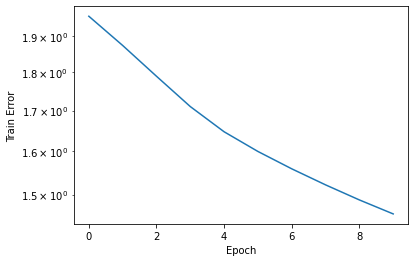

7.463299044284041

In [33]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.anime_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

## non-negative matrix factorization

In [36]:
from keras.constraints import non_neg

latent_dim = 5

anime_input = Input(shape=[1],name='anime-input')
anime_embedding = Embedding(num_animes + 1, latent_dim, name='anime-embedding',
                                                        embeddings_constraint=non_neg())(anime_input)
anime_vec = Flatten(name='anime-flatten')(anime_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding',
                                                      embeddings_constraint=non_neg())(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = dot([anime_vec, user_vec], axes=1, normalize=False, name='dot-product')

model = Model([user_input, anime_input], prod)
model.compile('adam', 'mean_squared_error')

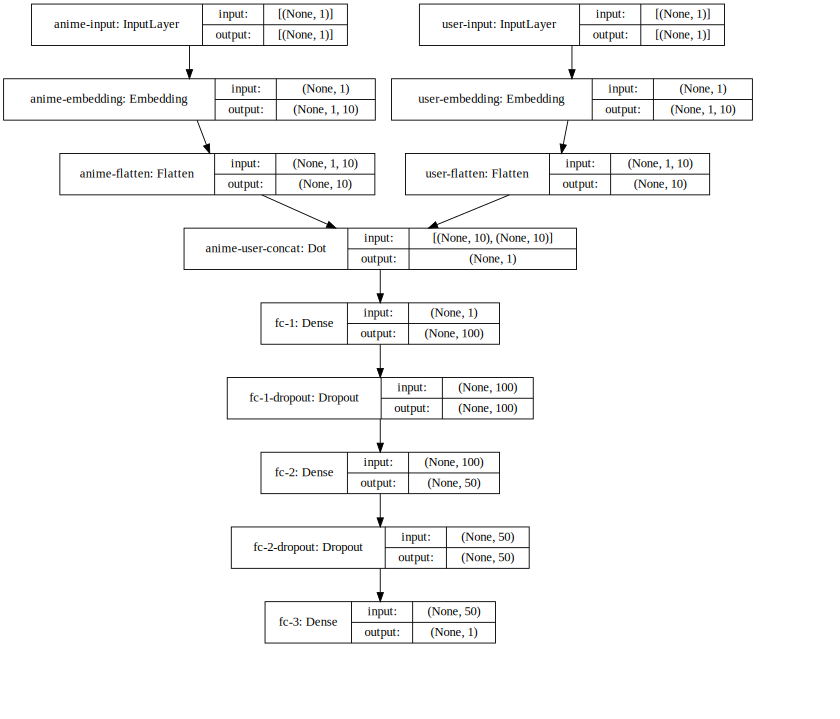

In [46]:
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [40]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anime-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime-embedding (Embedding)     (None, 1, 5)         60535       anime-input[0][0]                
__________________________________________________________________________________________________
user-embedding (Embedding)      (None, 1, 5)         20180       user-input[0][0]                 
____________________________________________________________________________________________

Epoch 1/10
20561/20561 [==============================] - 55s 3ms/step - loss: 3.1765
Epoch 2/10
20561/20561 [==============================] - 52s 3ms/step - loss: 3.1229
Epoch 3/10
20561/20561 [==============================] - 54s 3ms/step - loss: 3.1216
Epoch 4/10
20561/20561 [==============================] - 55s 3ms/step - loss: 3.1217
Epoch 5/10
20561/20561 [==============================] - 56s 3ms/step - loss: 3.1210
Epoch 6/10
20561/20561 [==============================] - 56s 3ms/step - loss: 3.1213
Epoch 7/10
20561/20561 [==============================] - 56s 3ms/step - loss: 3.1213
Epoch 8/10
20561/20561 [==============================] - 57s 3ms/step - loss: 3.1216
Epoch 9/10
20561/20561 [==============================] - 57s 3ms/step - loss: 3.1200
Epoch 10/10
20561/20561 [==============================] - 56s 3ms/step - loss: 3.1214


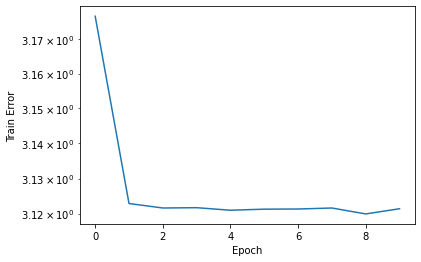

1.379866734758396

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

history = model.fit([train.user_id, train.anime_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.anime_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

# Multi-Layer Perceptron

In [53]:
from keras.layers import  BatchNormalization

latent_dim = 10

# Define inputs
anime_input = Input(shape=[1],name='anime-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
anime_embedding_mlp = Embedding(num_animes + 1, latent_dim, name='anime-embedding-mlp')(anime_input)
anime_vec_mlp = Flatten(name='flatten-anime-mlp')(anime_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
anime_embedding_mf = Embedding(num_animes + 1, latent_dim, name='anime-embedding-mf')(anime_input)
anime_vec_mf = Flatten(name='flatten-anime-mf')(anime_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([anime_vec_mlp, user_vec_mlp], axis=1, name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = dot([anime_vec_mf, user_vec_mf], axes=1, normalize=False, name='pred-mf')
combine_mlp_mf = concatenate([pred_mf, pred_mlp], axis=1, name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, anime_input], result)
model.compile(Adam(learning_rate=0.01), loss='mean_absolute_error')

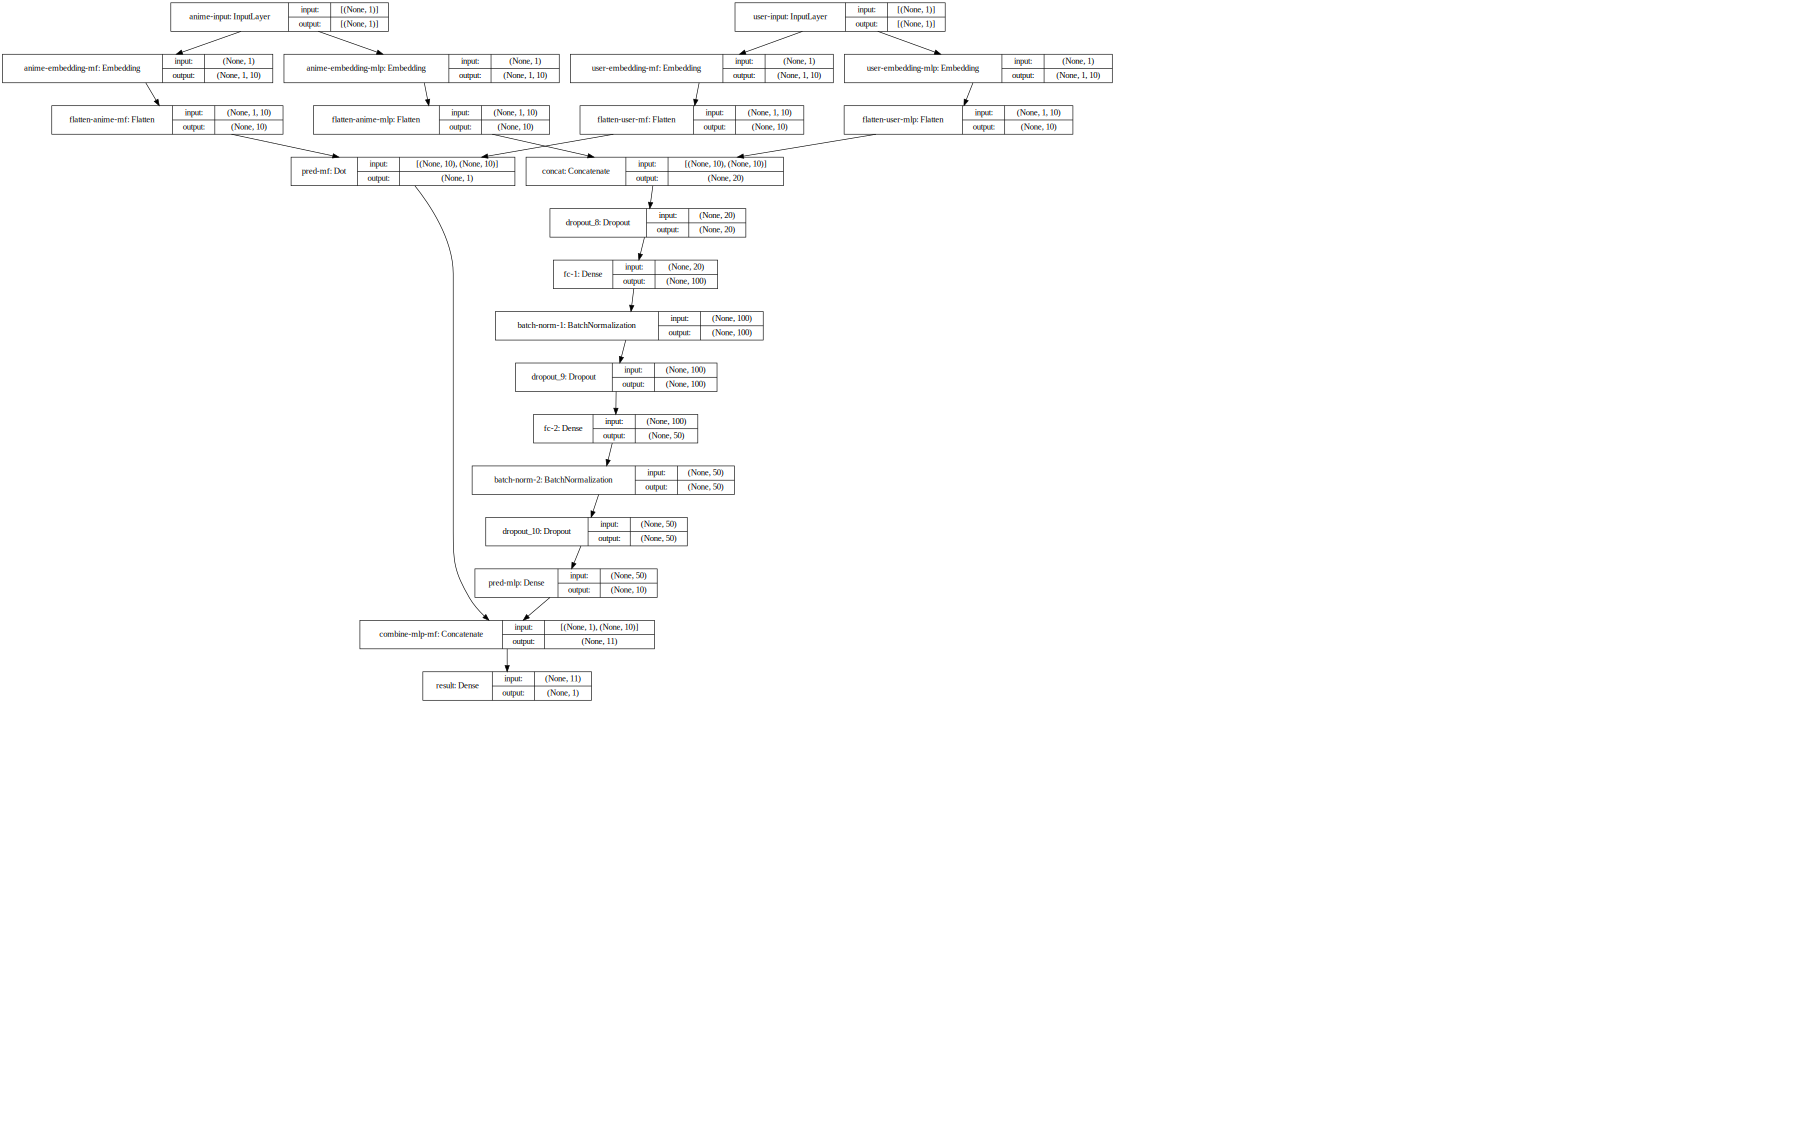

In [57]:
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=45).create(prog='dot', format='svg'))

In [58]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anime-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime-embedding-mlp (Embedding) (None, 1, 10)        121070      anime-input[0][0]                
__________________________________________________________________________________________________
user-embedding-mlp (Embedding)  (None, 1, 10)        40360       user-input[0][0]                 
____________________________________________________________________________________________

Epoch 1/10
20561/20561 [==============================] - 74s 4ms/step - loss: 1.1266
Epoch 2/10
20561/20561 [==============================] - 77s 4ms/step - loss: 1.0372
Epoch 3/10
20561/20561 [==============================] - 74s 4ms/step - loss: 1.0214
Epoch 4/10
20561/20561 [==============================] - 75s 4ms/step - loss: 1.0121
Epoch 5/10
20561/20561 [==============================] - 75s 4ms/step - loss: 1.0078
Epoch 6/10
20561/20561 [==============================] - 78s 4ms/step - loss: 1.0026
Epoch 7/10
20561/20561 [==============================] - 78s 4ms/step - loss: 0.9970
Epoch 8/10
20561/20561 [==============================] - 78s 4ms/step - loss: 0.9915
Epoch 9/10
20561/20561 [==============================] - 76s 4ms/step - loss: 0.9816
Epoch 10/10
20561/20561 [==============================] - 76s 4ms/step - loss: 0.9634


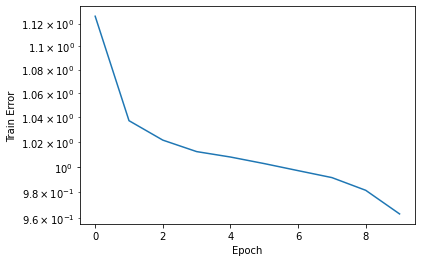

0.9779167024661547

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.user_id, train.anime_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.anime_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)